In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline
import tensorflow as tf
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
sms = pd.read_csv('/kaggle/input/sms-spam-classifier2/spam.csv', encoding='latin-1',
usecols=[0,1], skiprows=1,
names=["label", "message"])
sms.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
 sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [47]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [48]:
sms.isnull().sum()

label      0
message    0
dtype: int64

In [49]:
sms['label'] = sms['label'].apply(lambda x: 1 if x == 'spam' else 0)
sms['label']=sms['label'].astype(int)

In [50]:
sms.duplicated().sum(),sms.shape

(403, (5572, 2))

In [51]:
sms=sms.drop_duplicates(keep='first')
sms.shape

(5169, 2)

Exploratory Data Analysis(EDA)

In [52]:
sms['label']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5169, dtype: int64

In [53]:
sms['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

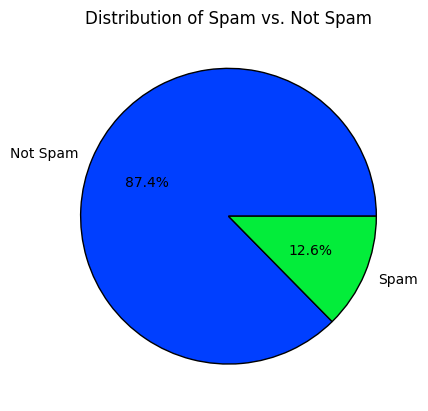

In [54]:
plt.pie(sms['label'].value_counts(),labels=['Not Spam','Spam'], autopct='%1.1f%%')
plt.title('Distribution of Spam vs. Not Spam')
plt.show()

Converting text to Feature(Feature extraction) 

In [55]:
sms['num_char']=sms['message'].apply(len)
sms.head()

,label,message,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [63]:
sms['num_sent']=sms['message'].apply(lambda x : len(sent_tokenize(x)))
sms.head()

,label,message,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [58]:
sms['num_words']=sms['message'].apply(lambda x : len(word_tokenize(x)))
sms.head()

,label,message,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,23
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


EDA FOR Messages 

In [64]:
sms[['num_char','num_words','num_sent']]

,num_char,num_words,num_sent
0,111,23,2
1,29,8,2
2,155,37,2
3,49,13,1
4,61,15,1
...,...,...,...
5567,161,35,4
5568,37,9,1
5569,57,15,2
5570,125,27,1


In [65]:
sms[['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.286129,1.961308
std,58.236293,13.226400,1.432583
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,219.000000,38.000000


In [66]:
sms[sms['label']==1][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


In [67]:
sms[sms['label']==0][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.957484,1.815545
std,56.358207,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


<Axes: xlabel='num_char', ylabel='Count'>

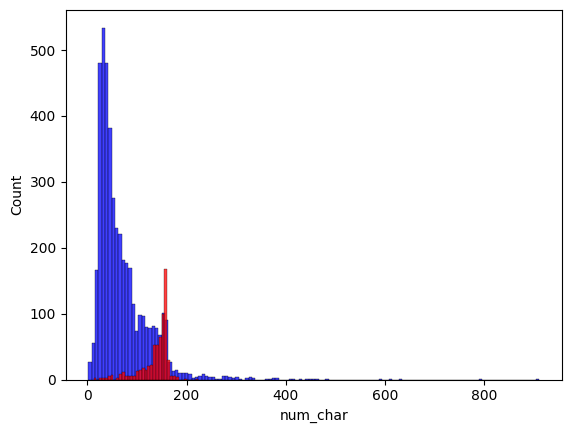

In [68]:
sns.histplot(sms[sms['label'] == 0]['num_char'], color='blue')
sns.histplot(sms[sms['label'] == 1]['num_char'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

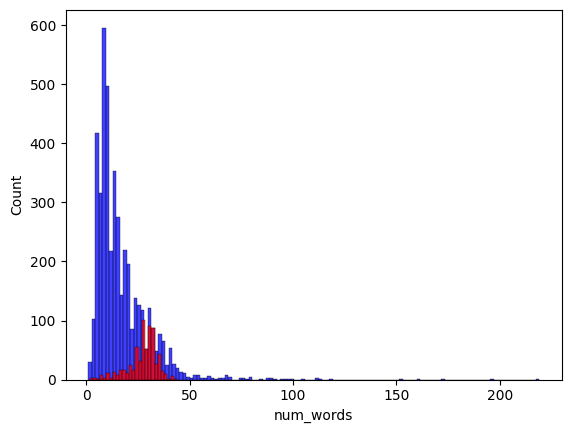

In [69]:
sns.histplot(sms[sms['label'] == 0]['num_words'], color='blue')
sns.histplot(sms[sms['label'] == 1]['num_words'], color='red')

<Axes: xlabel='num_sent', ylabel='Count'>

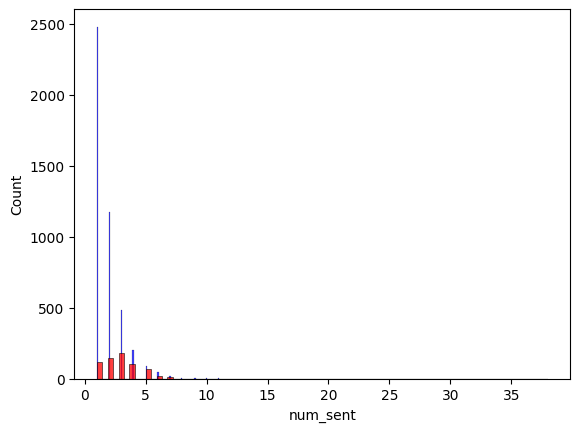

In [70]:
sns.histplot(sms[sms['label'] == 0]['num_sent'], color='blue')
sns.histplot(sms[sms['label'] == 1]['num_sent'], color='red')

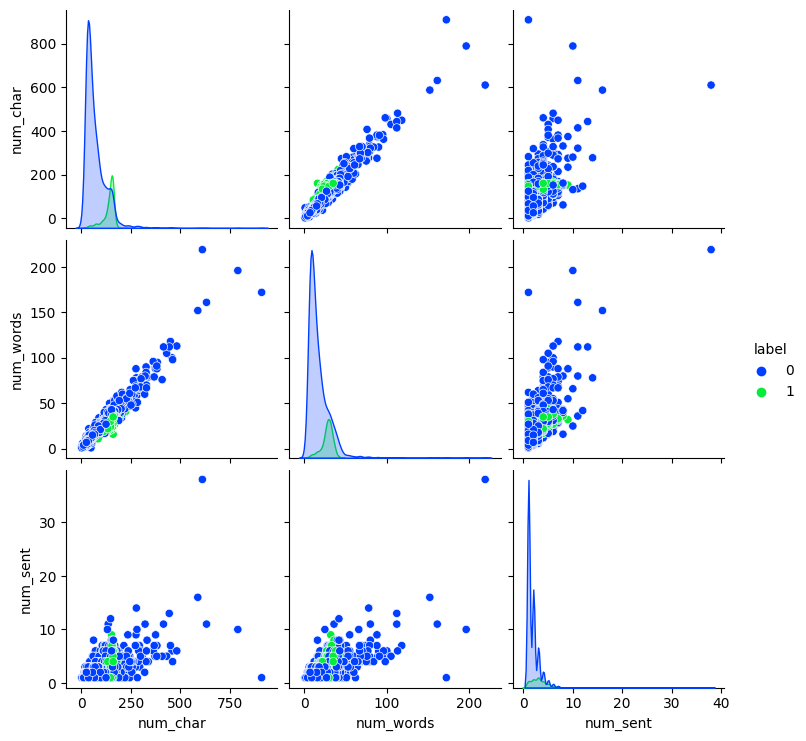

In [71]:
sns.pairplot(sms,hue='label')

<Axes: >

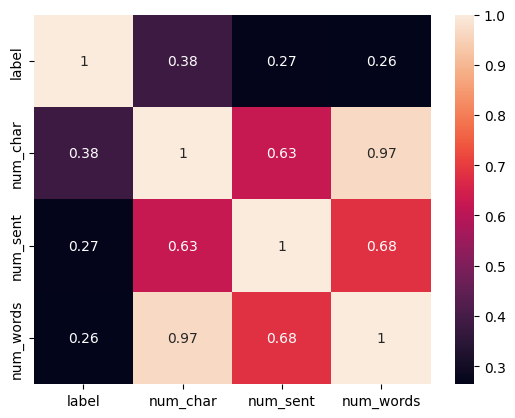

In [72]:
sns.heatmap(sms[['label','num_char','num_sent','num_words']].corr(),annot=True)

Data Processing

* Lower case
* Tokenization
* Removing special characters
* Removing stop words and punctuation
* Stemming

In [74]:
import re
from nltk.corpus import stopwords
import string 
punctuation= string.punctuation
nltk.download('punkt')
#!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~



nltk.download('stopwords')
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
# going -> go  ,sleeps ->sleep 



def text_transform(x):
  x=x.lower()
  x = nltk.word_tokenize(x)
  x=[word for word in x if (word not in stop_words) and (word.isalnum()) and (word not in punctuation)]
  x = [stemmer.stem(word) for word in x]

  return " ".join(x)


text_transform("HI HOW ARE YOU ? !,  he goes to sleep   ")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'hi goe sleep'

In [75]:
(text_transform(sms['message'][0]))

'go jurong point avail bugi n great world la e buffet cine got amor wat'

In [76]:
(sms['message'][0])

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [77]:
sms['text_transformed']=sms['message'].apply(text_transform)
sms.head()

,label,message,num_char,num_words,num_sent,text_transformed
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


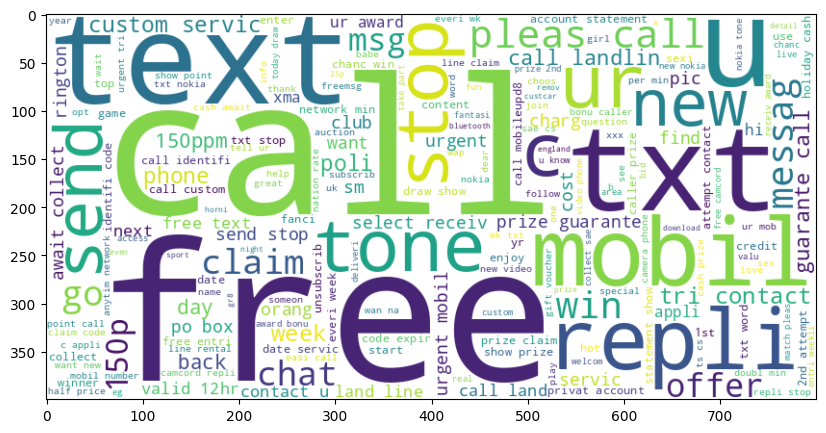

In [79]:
#spam 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(   
    
    (sms[sms['label']==1]['text_transformed']).str.cat(sep=" ")
)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

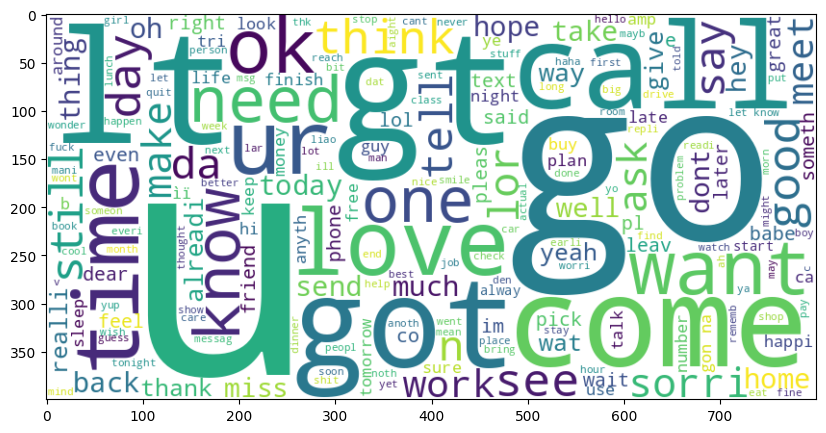

In [80]:
#spam 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(   
    
    (sms[sms['label']==0]['text_transformed']).str.cat(sep=" ")
)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Model Building such as navie bayes, svc and logestic regression 

In [82]:
cv=CountVectorizer()
X=cv.fit_transform(sms['text_transformed']).toarray() 
X.shape, sms['text_transformed'].shape

((5169, 6629), (5169,))

In [84]:
y=sms['label'].values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,y_train)
nb_pred = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_report = classification_report(y_test, nb_pred)
nb_accuracy

0.9729206963249516

In [88]:
lg = LogisticRegression(C=20.0,max_iter=1000)
lg.fit(X_train,y_train)
lg_pred = lg.predict(X_test)
lg_accuracy = accuracy_score(y_test, lg_pred)
lg_report = classification_report(y_test, lg_pred)
lg_accuracy

0.9825918762088974

In [89]:
sv = SVC(C=10.0)
sv.fit(X_train,y_train)
sv_pred = sv.predict(X_test)
sv_accuracy = accuracy_score(y_test, sv_pred)
sv_report = classification_report(y_test, sv_pred)
sv_accuracy

0.9748549323017408

In [90]:
print("Naive Bayes Classifier:")
print(f"Accuracy: {nb_accuracy:.2f}")
print("Classification Report:\n", nb_report)

print("\nLogistic Regression Classifier:")
print(f"Accuracy: {lg_accuracy:.2f}")
print("Classification Report:\n", lg_report)

print("\nSupport Vector Machine Classifier:")
print(f"Accuracy: {sv_accuracy:.2f}")
print("Classification Report:\n", sv_report)

Naive Bayes Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       889
           1       0.89      0.92      0.91       145

    accuracy                           0.97      1034
   macro avg       0.94      0.95      0.94      1034
weighted avg       0.97      0.97      0.97      1034


Logistic Regression Classifier:
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.99      0.88      0.93       145

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034


Support Vector Machine Classifier:
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       1.00    